# Dynamic iterative inverse for Nyströmformer

In its current version, Nyströmformer uses a fixed number of steps (6) to iteratively calculate pseudoinverse matrices. The choice of this number neither well proven nor seems appropiate given that selected iterative method may diverge for some matrices. Also its convergence speed depends on the size of the matrix, which also varies with the number of landmarks being used by Nyströmformer.

This notebooks plays with the idea of using some stop criteria for determining "on the fly" how many steps to take for each batch of matrices. Its main code is in `dynamic_iterative_inv` function. Roughly speaking, `dynamic_iterative_inv` at each step calculates an error $|| AV_n - I ||$ with a scaled Frobenius norm $||X|| = \sqrt{{1 \over n^2} \sum_{i=1}^{n} \sum_{j=1}^{n} |x_{i,j}|^2}$ (which doesn't depend on the size of the matrix). This error always drops monotonically until the algorithm converges to a solution. It may start rising again only if the algorithm diverges (in case of ill-conditioned matrix for example). So the idea is when this error drops to near zero, or its descend slows to a crawl, we stop the process. For testing purposes, this notebook also calculates pseudoinverse matrices using [`torch.linalg.pinv`](https://pytorch.org/docs/master/linalg.html#torch.linalg.pinv) as baseline and accumulates a second error $|| pinv(A) - V_n ||$ so the two could be compared.

Another issue is that we work with a bunch of matrices at once. For some of them the algorithm will converge faster. For some others it will never converge at all. This code can also ignore "the slowest members" when the majority of the solutions is ready (controlled by the `ignore_slowest` parameter). In any case, those solutions that have already converged will keep on improving (if possible) while waiting for the rest of them.

The code is somewhat intentionally over-bloated. Once the best working strategy is determined, the rest can be thrown away.

In [1]:
from typing import Literal
import itertools

import torch
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors


def initial_inv_matrix(A: torch.Tensor, from_softmax: bool) -> torch.Tensor:
    A_t = A.transpose(-2, -1)
    A_abs = A.abs()
    A_norm1 = A_abs.sum(dim=-2, keepdim=True).max(dim=-1, keepdim=True).values
    if from_softmax:
        V0 = A_t / A_norm1
    else:
        A_norm_inf = A_abs.sum(dim=-1, keepdim=True).max(dim=-2, keepdim=True).values
        V0 = A_t / (A_norm1 * A_norm_inf)
    return V0


def scaled_frobenius_norm(A) -> torch.Tensor:
    return A.square().mean(dim=(-2, -1), keepdim=True).sqrt()


def dynamic_iterative_inv(
        A: torch.Tensor,
        atol: float = 1e-4,
        min_conv_speed: float = 1e-4,
        warmup_steps: int = 5,
        max_steps: int = 30,
        from_softmax: bool = False,
        ignore_slowest: float = 0,
        method: Literal['original', 'alternative'] = 'original'):
    """
    Calculates inverse matrix using an iterative algorithm, dynamically
    adjusting the number of steps.

    Based on "A New Iterative Method for Finding Approximate Inverses
    of Complex Matrices" by M. Kafaei Razavi et al.
    https://www.hindawi.com/journals/aaa/2014/563787/

    This implementation tracks its progress and stops when it believes
    the result cannot be further improved either because it is already
    good enough, or because the rate of progress is too slow, or because
    it began to diverge/became unstable. For that it analyzes
    the difference between `matmul(A, inverse(A))` and an identity matrix
    of the same size ("the error" later in the text).

    :param A: a square matrix the inverse of which needs to be found,
        or a batch of such matrices.
    :param atol: absolute tolerance for the error.
        The algorithm will stop if the error drops below the threshold given
        by this parameter (for all matrices being processed in the batch).
        On its own this parameter isn't sufficient since finding the inverse
        matrix isn't always possible, this expression `matmul(A, inverse(A))`
        will never become equal to `I` and the error will never drop to atol.

        So there are other stop criteria, linked to the convergence issues.
        The algorithm stops if, for any of the matrices:

            1. the error (the difference from the above) becomes zero or
               begins to raise instead of gradually falling.
            2. the error becomes non-finite (nan or inf).
            3. the speed of convergence slows below `min_conv_speed`
               after the first `warmup_steps`.

        In both cases tha last known *valid* result will be returned,
        even if the current iteration failed.
    :param min_conv_speed: minimum required difference in the error between
        steps to keep the computation going. If the difference becomes
        too small after the first `warmup_steps`, the algorithm stops
        and returns the achieved result.
    :param warmup_steps: initially the algorithm progresses toward the solution
        slowly, gaining speed with each step. If we start checking its
        convergence speed against `min_conv_speed` too soon, we would often
        be stopping prematurely. So we don't do that during the first
        `warmup_steps`. This doesn't interfere with the other stop criteria.
    :param max_steps: the maximum number of steps the algorithm is allowed
        to run. When reached, the last calculated approximation will
        be returned.
    :param from_softmax: Indicates that the input matrix is a result
        of softmax operation along the last axis. Which means that
        the sum of all elements per row is equal to 1. This makes inf-norm
        of the matrix also equal to 1 and simplifies inital matrix calculation.
    :param ignore_slowest: a number from 0 to 1 giving the percentage
        of slowly converging pseudo-inverse matrices that we can stop
        improving if rest of the matrices have already met their requirements
        (set by `atol` and `min_conv_speed`). ignore_slowest = 0 means
        we wait until the last of the matrices in the batch finally
        converges.
    :param method: "original", which is currently used in Nystromformer method
        from "Chebyshev-type methods and preconditioning techniques" by Li et al,
        or an "alternative" method from "A New Iterative Method for Finding
        Approximate Inverses of Complex Matrices" by Razavi et al.
    :returns: a tuple, containing the last known solution at the moment
        one of the stop conditions was met, plus the number of steps
        it took to reach the solution.
    """
    A_pinv = torch.linalg.pinv(A)
    I = torch.eye(A.shape[-1], dtype=A.dtype)
    V = initial_inv_matrix(A, from_softmax)
    AV = torch.matmul(A, V)
    last_error = scaled_frobenius_norm(I - AV)
    num_matrices = last_error.numel()
    i = 0
    is_next_iter_possible = torch.isfinite(last_error)
    num_not_finished = is_next_iter_possible.float().sum()
    baseline_error = scaled_frobenius_norm(V - A_pinv)
    stat = [torch.stack([last_error.squeeze(), baseline_error.squeeze()], dim=-1)]
    while (num_not_finished / num_matrices).item() > ignore_slowest and i < max_steps:
        # the algorithm itself
        if method == 'original':
            # Currently used in Nyströmformer
            new_V = 0.25 * torch.matmul(V, 13 * I - torch.matmul(AV, 15 * I - torch.matmul(AV, 7 * I - AV)))
        elif method == 'alternative':
            # This method has about twice higher rate of convergence but about twice more expensive to compute.
            # However, less steps means less errors to check, so overall it often wins.
            zeta = -11 * I + torch.matmul(AV, 25 * I + torch.matmul(AV, -30 * I + torch.matmul(AV, 20 * I + torch.matmul(AV, -7 * I + AV))))
            new_V = -0.25 * torch.matmul(torch.matmul(V, zeta), 4 * I + torch.matmul(AV, zeta))
        else:
            raise ValueError('Unknown method {!r}'.format(method))
        new_AV = torch.matmul(A, new_V)
        # Start of a bunch of checks
        new_error = scaled_frobenius_norm(I - new_AV)
        new_baseline_error = scaled_frobenius_norm(new_V - A_pinv)
        # Can we use this iteration's results (are they valid)?
        # if the error is non-finite (nan/inf) that means some
        # elements of the matrix have gone haywire and we must stop
        # and fall back to the previous (valid) result.
        # Another bad sign is a frozen or even growing error.
        result_is_valid = torch.logical_and(
            torch.isfinite(new_error),
            new_error < last_error)
        # For as long as we have some matrices that haven't hit
        # their goals in terms of the absolute error or the convergence speed,
        # other matrices will keep on improving while their respective iteration
        # results remain valid.
        is_next_iter_possible = torch.logical_and(
            is_next_iter_possible,
            torch.logical_and(
                result_is_valid,
                torch.logical_and(
                    new_error > atol,
                    torch.logical_or(
                        torch.tensor(i < warmup_steps),
                        last_error - new_error > min_conv_speed))))
        # if the last result is invalid, we fall back to the previous one
        # and keep doing the same every cycle until we have done with
        # all the matrices.
        V = torch.where(result_is_valid, new_V, V)
        AV = torch.where(result_is_valid, new_AV, AV)
        last_error = torch.where(result_is_valid, new_error, last_error)
        baseline_error = torch.where(result_is_valid, new_baseline_error, baseline_error)
        i += 1
        num_not_finished = is_next_iter_possible.float().sum()
        stat.append(torch.stack([last_error.squeeze(), baseline_error.squeeze()], dim=-1))

    return V, torch.stack(stat, dim=-2)

def plot_errors(stat, title):
    fig,ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.set_xlabel('step')
    ax1.set_ylabel('|| I - AV ||')
    ax2.set_ylabel('|| AV - pinv(A) ||   (dashed)')
    for matrix_id, color in zip(range(stat.shape[0]), itertools.cycle(mcolors.TABLEAU_COLORS.keys())):
        ax1.plot(stat[matrix_id, :, 0], color=color)
        ax2.plot(stat[matrix_id, :, 1], '--', color=color)
    ax1.set_title(title)
    ax1.set_ylim((0, 1.05*stat[:, :, 0].max().item()))
    ax2.set_ylim((0, 1.05*stat[:, :, 1].max().item()))
    fig.tight_layout()

## Some experiments on random matrices

Trying to emulate 64 and 128 landmarks and compare the length of runs for two different iterative methods.
Runs on the real attention matrices produce very similar results.

In [2]:
NUM_MATRICES = len(mcolors.TABLEAU_COLORS)
A64 = torch.softmax(torch.randn(NUM_MATRICES, 64, 64), dim=-1)
A128 = torch.softmax(torch.randn(NUM_MATRICES, 128, 128,), dim=-1)

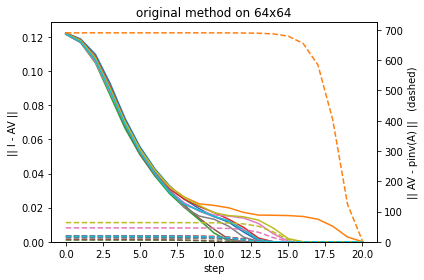

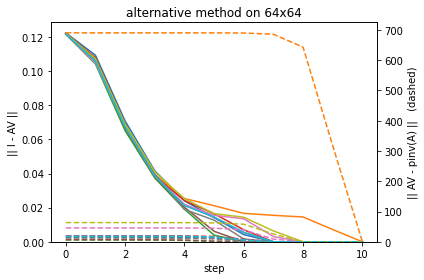

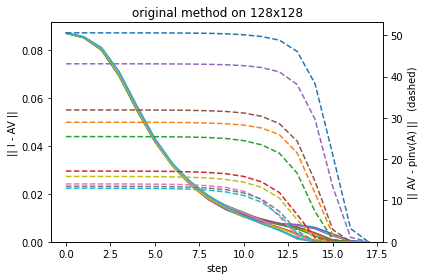

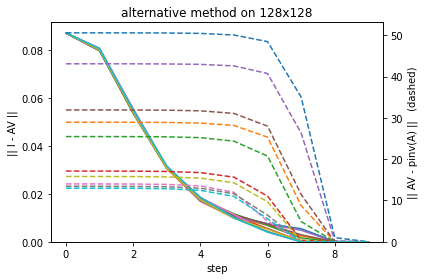

In [3]:
for matrix in (A64, A128):
    for method in ('original', 'alternative'):
        V, stat = dynamic_iterative_inv(matrix, method=method)
        plot_errors(stat, '{} method on {}x{}'.format(method, *matrix.shape[-2:]))

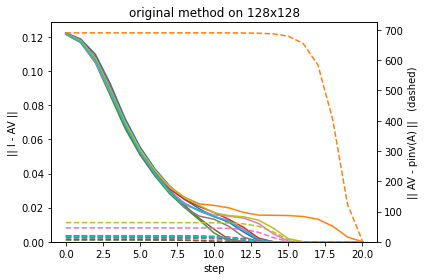

In [4]:
V, stat = dynamic_iterative_inv(A64)
plot_errors(stat, 'original method on 128x128')

## Trying to jog the conditions to get the same 6 steps or close without hard-coding the number

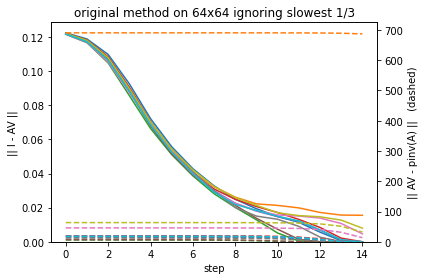

In [5]:
V, stat = dynamic_iterative_inv(A64, ignore_slowest=1/3)
plot_errors(stat, 'original method on 64x64 ignoring slowest 1/3')

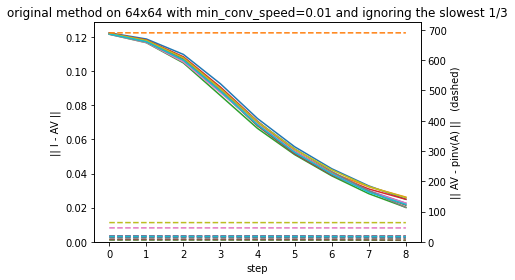

In [6]:
V, stat = dynamic_iterative_inv(A64, ignore_slowest=1/3, min_conv_speed=0.01)
plot_errors(stat, 'original method on 64x64 with min_conv_speed=0.01 and ignoring the slowest 1/3')

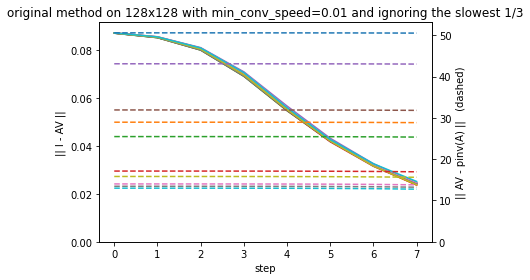

In [7]:
V, stat = dynamic_iterative_inv(A128, ignore_slowest=1/3, min_conv_speed=0.01)
plot_errors(stat, 'original method on 128x128 with min_conv_speed=0.01 and ignoring the slowest 1/3')

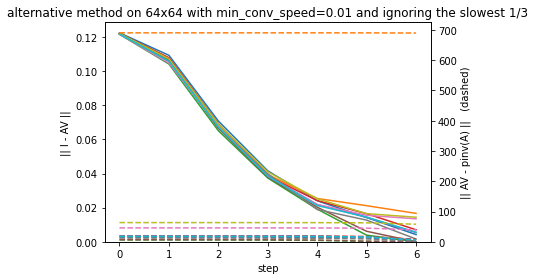

In [8]:
V, stat = dynamic_iterative_inv(A64, ignore_slowest=1/3, min_conv_speed=0.01, method='alternative')
plot_errors(stat, 'alternative method on 64x64 with min_conv_speed=0.01 and ignoring the slowest 1/3')

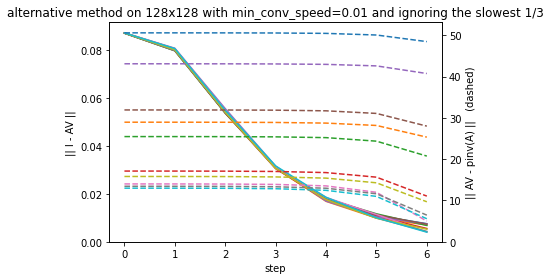

In [9]:
V, stat = dynamic_iterative_inv(A128, ignore_slowest=1/3, min_conv_speed=0.01, method='alternative')
plot_errors(stat, 'alternative method on 128x128 with min_conv_speed=0.01 and ignoring the slowest 1/3')